# <center> Clustering Project <center/>
<center> DLBDSMLUSL01 - Machine Learning : Unsupervised Learning <center/>
<center> IU International University of Applied Sciences <center/>

# Greetings
Human Resources of our company would like to mitigate mental health issues among the company’s staff through a pre-emptive program. This program will be based on this quantitative analysis of [data](https://www.kaggle.com/datasets/osmi/mental-health-in-tech-2016/) resulting from anonymous surveys from people working in IT-related companies around the world.

### List of contents :
1. _Introduction_
2. _Exploratory Data Analysis (EDA)_
3. _Data Pre-processing_
4. __Clustering__
5. _Clusters Profiling_

Importing the required libraries

In [1]:
# Tools for clustering 
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans 
from prince import MCA 

# Tools for visualization
from yellowbrick.cluster.elbow import KElbowVisualizer
import matplotlib.pyplot as plt 
import seaborn as sns
from umap import UMAP

# Tools for Data analysis and manipulation 
import pandas as pd
import numpy as np

from pathlib import Path  # Path library for generating OS paths efficiently
import warnings # Handle warnings

In [2]:
# Ignoring irrelevant warnings
warnings.filterwarnings('ignore')

We start by loading the data, recall that the data folder contains the following files:
- __mental-heath-in-tech-2016_20161114.csv__ : Raw data downloaded from kaggle.
- __data_v0.5.csv__ : Classified data.
- __data_v1.0.csv__ : Cleaned data.
- __data_v2.0.csv__ : Encoded data.
- __data_v2.1.csv__ : Encoded data with no correlated features.

In [3]:
# Formulating the directory 
path = Path.cwd().parent

# Loading the data
df = pd.read_csv(f'{path}/data/data_v2.1.csv')
original_df = pd.read_csv(f'{path}/data/data_v1.0.csv')

# Displaying the data
df.head()

,is_self_employed,organization_size,is_tech_company,is_mh_benefits_provided,is_aware_mh_care_available,is_mh_discussed_by_employer,is_mh_resources_provided_by_employer,is_anonymity_protected,how_is_asking_for_medical_leave_due_to_mhi,is_discussing_mhd_with_employer_have_negative_consequences,...,previous_history_of_mhi,is_having_mhd,diagnosed_by_professional,is_sought_treatment_for_mhi,is_mhi_interferes_with_your_work_when_treated_effectively,is_mhi_does_not_interfere_with_your_work_when_treated_effectively,age,gender,role_description,is_remote
0,0,2,1,2,1,1,1,0,5,1,...,2,1,1,0,1,1,1,1,3,2
1,0,4,1,1,2,2,2,2,3,1,...,2,2,1,1,3,4,0,1,3,1
2,0,4,1,1,1,1,1,0,1,0,...,0,1,0,1,1,1,1,1,3,0
3,1,2,1,3,1,1,1,0,3,0,...,2,2,1,1,4,4,2,1,4,2
4,0,4,0,3,2,1,1,1,1,2,...,2,2,1,1,4,4,2,0,4,2


In [4]:
print(f"The data is formed through {df.shape[1]} columns/features and {df.shape[0]} rows/records.")

The data is formed through 46 columns/features and 1433 rows/records.


## 4. Clustering

### 4.1 Dimensionality reduction
Many approaches are available for reducing dimensionality in the dataset. For our case, we'll proceed with Multiple Correspondence Analysis __(MCA)__. 

We'll start by considering the number of components we'll be using with our algorithm. For this matter, we'll be using a number of components with a minimum 80% of explained variance.  

In [5]:
# Numbers list of components to try
components_list = [i + 1 for i in range(100)]

# Dictionary to store the cumulative explained variance for each number of components
cumulative_variance = {}

# Iterate through each number of components
for n in components_list:
    # Initialize and fit the MCA model with the current number of components
    mca = MCA(n_components=n, n_iter=2, random_state=42)
    mca.fit(df)

    # Get the cumulative explained variance for the current number of components
    cumulative_variance[n] = mca.eigenvalues_summary["% of variance (cumulative)"].iloc[-1]

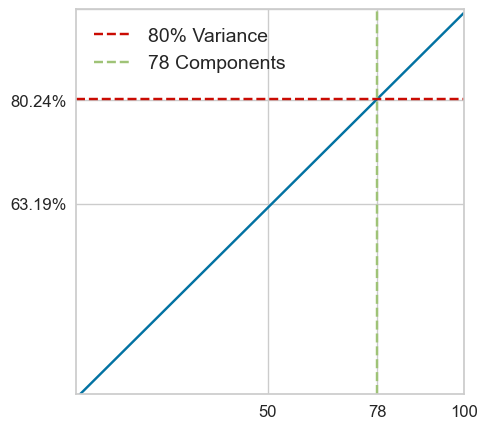

In [6]:
# Set the size of the figure
plt.figure(figsize=(5, 5))

# Plot the data
plt.plot(components_list, cumulative_variance.values(), marker='+', color='b', linestyle='-')

# Label x-axis
plt.xlabel('')
plt.xticks([0, 50, 78, 100], fontsize=12)  # Set font size for x-axis ticks

# Label y-axis
plt.ylabel('') 
plt.yticks([0, 50, 76.6, 100], fontsize=12)  # Set font size for y-axis ticks

# Limit the values on both axes
plt.xlim(1, 100)
plt.ylim(1, 100)

# Highlight 80% cumulative explained variance and Highlight 78 components
plt.axhline(y=77, color='r', linestyle='--', label='80% Variance')
plt.axvline(x=78, color='g', linestyle='--', label='78 Components')

# Add legend
plt.legend(fontsize=14)

# Sav the figure
plt.savefig(f'{path}/assets/Fig11 - The explained variance.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

Then, our algorithm will look something like this 

In [7]:
# Initiate MCA instance with 78 components and 2 iterations
mca = MCA(n_components=78, n_iter=2, random_state=0)

# Fit and transform the data using MCA
mca_results = mca.fit_transform(df)

### 4.2 Data Clustering
It's in this section happens wait we've been waiting for since the early phases. Using the data we prepared, we'll proceed to cluster the data using KMeans algorithm.

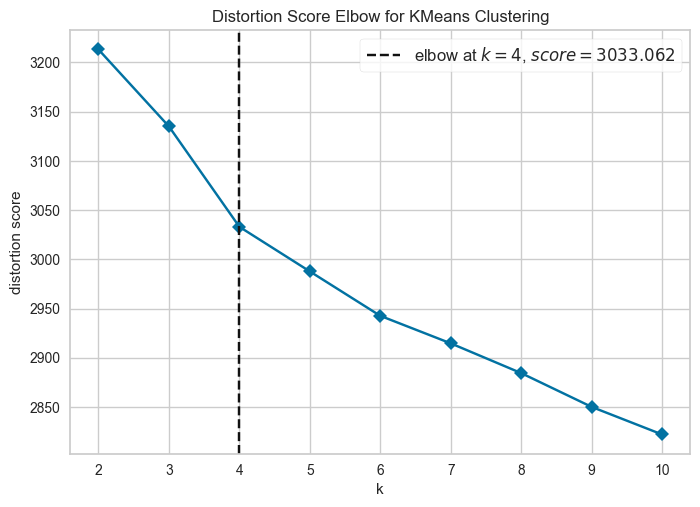

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
# Start a model
model = KMeans(random_state=314, max_iter=20)

# Initialise and fit the data using the visualizer
visualizer = KElbowVisualizer(model, timings=False, k=10)
visualizer.fit(mca_results)

# Show the plot 
visualizer.show()

After specifying the number of clusters required, we delve into clustering the data.

In [9]:
# Initiating an instance of K-Means
kmeans = KMeans(n_clusters=4, 
                random_state=314, 
                n_init='auto',
                init='k-means++', 
                max_iter=250)

# Generating predictions and storing them in 
clustered = kmeans.fit_predict(mca_results)

# Assign the centroids and labels 
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

Although the clustering is done here, an illustration is compulsory to get a feel of what we've done. 
In the next section, we'll plot the data using a specific tool called UMAP in 2D.

In [10]:
# Initiating an instance of UMAP
umap = UMAP(n_components=2, 
            random_state=0, 
            init='random')

# Combine data and centroids
combined_data = np.vstack([mca_results, centroids])
combined_labels = np.hstack([labels, ['centroid']*centroids.shape[0]])

# Fit and transform data
umap_results = umap.fit_transform(combined_data)

# Separate UMAP results
umap_mca_results = umap_results[:-centroids.shape[0]]
umap_centroids = umap_results[-centroids.shape[0]:]

# Issue a copy of the data for visualization purposes
mca_visuals = mca_results.copy()

# Add UMAP results to the mca_results DataFrame
mca_visuals['UMAP-1'] = umap_mca_results[:, 0]
mca_visuals['UMAP-2'] = umap_mca_results[:, 1]
mca_visuals['Cluster'] = [ f"Cluster {element + 1}" for element in labels]

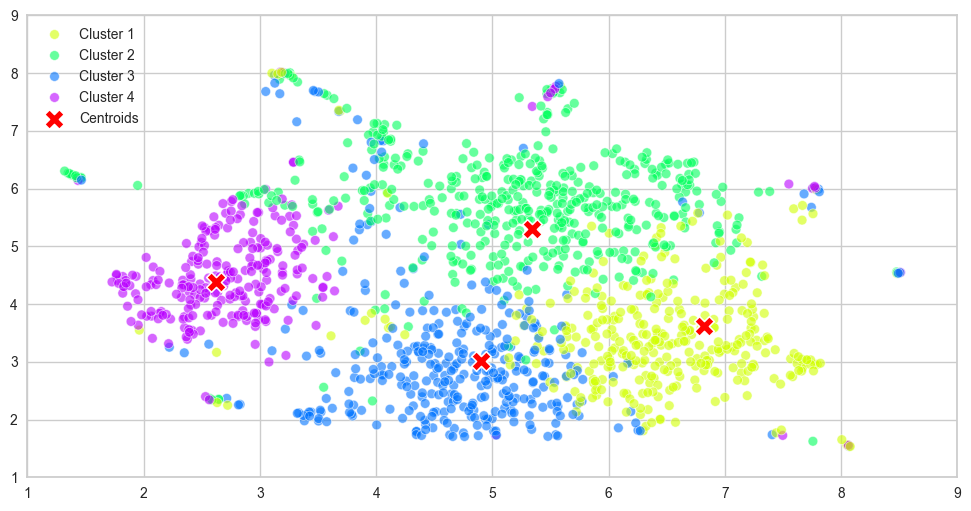

In [11]:
# Initiate a figure and set its size
plt.figure(figsize=(12, 6))

# Plot the scatter plot of datapoints 
ax = sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Cluster', hue_order=["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"],
                palette=sns.color_palette('hsv', len(np.unique(labels))),
                data=mca_visuals, alpha=0.6
                )

# Plot the centroids 
sns.scatterplot(
    x=umap_centroids[:, 0],
    y=umap_centroids[:, 1],
    color='red',
    s=200,
    marker='X',
    label='Centroids',
    ax=ax
)

# Show the legend
plt.legend(loc='upper left')

# Set the x-axis
plt.xlabel('')
plt.ylabel('')

# Set the y-axis
plt.xlim(1, 9)
plt.ylim(1, 9)

# Saving the plot
plt.savefig(f'{path}/assets/Fig12 - The UMAP representation of Data.png', bbox_inches='tight', dpi=300)


# Show the plot
plt.show()

In [12]:
# Initiating a for-loop
for i in range(4):
    # Getting the cluster size
    cluster_data = mca_results[labels == i]
    size = len(cluster_data)
    
    # Getting the average distance
    cluster_center = centroids[i]
    distance = np.mean(np.linalg.norm(cluster_data - cluster_center, axis=1))
    
    # Getting the proportion
    ratio = np.round((size/1433) * 100, decimals=2)
    
    # Print the results
    print(f'Cluster {i+1} | Size : {size} - Ratio : {ratio}% - Average distance: {np.round(distance, 3)}.')

Cluster 1 | Size : 347 - Ratio : 24.21% - Average distance: 1.494.
Cluster 2 | Size : 468 - Ratio : 32.66% - Average distance: 1.403.
Cluster 3 | Size : 359 - Ratio : 25.05% - Average distance: 1.48.
Cluster 4 | Size : 259 - Ratio : 18.07% - Average distance: 1.275.


### 4.3 Evaluating the clustering
Many metrics can be used for evaluating the quality of a clustering. In fact, we saw the Inertia score for the clustering __2996__ _(See the KElbowVisualizer in the previous section 4.2)_. The following metrics will also be used for the assessing the quality of our work :
- __Silhouette score__, A higher mean silhouette score indicates better-defined clusters.
- __Davies-Bouldin Index__, A lower score indicate better clustering.
- __Calinski-Harabasz Index__, A higher score indicate better clustering.

In [13]:
print("Silhouette :", round(silhouette_score(mca_results, labels), 5))
print("Davies-Bouldin Index :", round(davies_bouldin_score(mca_results, labels), 5))
print("Calinski-Harabasz Index :", round(calinski_harabasz_score(mca_results, labels), 5))

Silhouette : 0.04089
Davies-Bouldin Index : 3.92666
Calinski-Harabasz Index : 52.295


We'll conclude this phase by saving the clustering labels in the original cleaned dataset. 

In [14]:
# Add the cluster labels to the original cleaned dataset 
original_df["Cluster"] = labels

# Save the cleansed dataset in the respective directory
original_df.to_csv(f"{path}/data/data_v3.0.csv", index=False)

## Summary

In this notebook, we discussed the following aspects :
- Reducing the dimensionality of the dataset into a reduced space using MCA
- Clustering the data using the K-Means algorithm. 
- Evaluating the clustering using multiple metrics. 

## Author
<a href="https://www.linkedin.com/in/ab0858s/">Abdelali BARIR</a> is a former veteran in the Moroccan's Royal Armed Forces, and a self-taught python programmer. Currently enrolled in B.Sc. Data Science in __IU International University of Applied Sciences__.

## Change Log
| Date       | Version | Changed By     | Change Description      |
|------------|---------|----------------|-------------------------|
| 2024-03-10 | 1.0     | Abdelali Barir | Modified markdown       |
|------------|---------|----------------|-------------------------|